In [1]:
from sklearn.model_selection import train_test_split,cross_val_score, KFold,validation_curve,GridSearchCV
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score as r2
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor

In [2]:

data_reg=pd.read_excel('data_reg.xlsx')
data_class=pd.read_excel('data_class.xlsx')
data_reg_prep=pd.read_excel('data_reg_prep.xlsx')
data_class_prep=pd.read_excel('data_class_prep.xlsx')

data_reg_temp = data_reg.drop("SalePrice",axis = 1)
cols_temp = ["OverallQual","OverallCond","IsRemodGar","IsRemod"]
data_reg_temp[cols_temp]=data_reg_temp[cols_temp].astype("object")

cat_cols = data_reg_temp.select_dtypes(include = "object").columns.tolist()
print(len(cat_cols))
print(cat_cols)

num_cols = data_reg_temp.select_dtypes(include="number").columns.tolist()
print(len(num_cols))
print(num_cols)

Xtrain,Xtest,Ytrain,Ytest = train_test_split(data_reg_temp,data_reg["SalePrice"],test_size =0.3,random_state=0)
Xtrain = Xtrain.sort_index()
Xtest = Xtest.sort_index()
Ytrain= Ytrain.sort_index()
Ytest = Ytest.sort_index()

Xtrain_index = Xtrain.index.tolist()
Xtest_index = Xtest.index.tolist()

Xtrain_cat = Xtrain[cat_cols]

Xtrain_num = Xtrain[num_cols]
train_mean= Xtrain_num.mean()
train_std = np.sqrt(Xtrain_num.var())

Xtest_cat = Xtest[cat_cols]
Xtest_num = Xtest[num_cols]

Xtrain_num_std = Xtrain_num.apply(lambda x: (x - x.mean()) / np.sqrt(x.var())) 
Xtest_num_std = Xtest_num.copy()
for i in num_cols:
    Xtest_num_std[i] = (Xtest_num_std[i] - train_mean[i]) / train_std[i]

#axis = 0 caculate the mean or var through columns ,which is the default value in apply
# data_num_nor = data_num[numeric_cols].apply(lambda x: (x - x.min()) / (x.max(axis=0) - x.min(axis=0)))

#dummy的话最好一起dummy，因为有可能 test dataset 没有一些分类，导致train和test 的dummy的维度不一致

cat_dummy = data_reg_temp[cat_cols].copy()
for i in cat_cols:
    dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
    cat_dummy = pd.concat([cat_dummy,dummy_df], axis=1)
    cat_dummy = cat_dummy.drop(i, axis = 1)
print(cat_dummy.shape) 

Xtest_cat_dummy = cat_dummy.iloc[Xtest_index,:]
Xtrain_cat_dummy = cat_dummy.iloc[Xtrain_index,:]

Xtrain_lr = pd.concat((Xtrain_num_std,Xtrain_cat_dummy),axis = 1)
Xtest_lr = pd.concat((Xtest_num_std,Xtest_cat_dummy),axis = 1)
Ytrain_lr = Ytrain
Ytest_lr = Ytest

Xtrain_tree = pd.concat((Xtrain_num,Xtrain_cat),axis = 1)
Xtest_tree = pd.concat((Xtest_num,Xtest_cat),axis = 1)
Ytrain_tree = data_class.iloc[Xtrain_index,:]["PriceLevel"]
Ytest_tree = data_class.iloc[Xtest_index,:]["PriceLevel"]


# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Iterate through each column in Xtrain_tree
for column in Xtrain_tree.columns:
    # Check if the column is categorical (object data type)
    if Xtrain_tree[column].dtype == 'object':
        # Fit and transform the column with LabelEncoder
        Xtrain_tree[column] = label_encoder.fit_transform(Xtrain_tree[column])

for column in Xtest_tree.columns:
    # Check if the column is categorical (object data type)
    if Xtest_tree[column].dtype == 'object':
        # Fit and transform the column with LabelEncoder
        Xtest_tree[column] = label_encoder.fit_transform(Xtest_tree[column])

# Now Xtrain_tree contains the label-encoded categorical variables


20
['MSZoning', 'LotShape', 'HouseStyle', 'OverallQual', 'OverallCond', 'Exterior1st', 'MasVnrType', 'Foundation', 'BsmtQual', 'HeatingQC', 'CentralAir', 'KitchenQual', 'FireplaceQu', 'GarageType', 'GarageQual', 'PavedDrive', 'SaleType', 'SaleCondition', 'IsRemodGar', 'IsRemod']
9
['LotArea', 'YearBuilt', 'MasVnrArea', 'Fireplaces', 'GarAreaPerCar', 'GrLivAreaPerRoom', 'TotalHouseSF', 'TotalFullBath', 'TotalPorchSF']
(2930, 125)


C:\Users\T480S\AppData\Local\Temp\ipykernel_35336\3440473200.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
C:\Users\T480S\AppData\Local\Temp\ipykernel_35336\3440473200.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
C:\Users\T480S\AppData\Local\Temp\ipykernel_35336\3440473200.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  dummy_df = pd.get_dummies(cat_dummy[i], prefix=i,dtype=int)
C:\Users\T480S\AppData\Local\Temp\ipykernel_35336\3440473200.py:48: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when

In [4]:
reg = XGBRegressor(n_estimators=100).fit(Xtrain_tree,Ytrain_lr)
reg.predict(Xtest_tree) 
print(reg.score(Xtest_tree,Ytest_lr)) #R**2
print(np.sqrt(mse(Ytest_lr,reg.predict(Xtest_tree))))

0.8271054199059815
34633.366315274645


In [30]:
kf = KFold(n_splits=2, shuffle=True, random_state=0)
# custom_decision_tree = DecisionTreeRegressor(max_depth=16
#                                             ,min_samples_leaf= 1
#                                             ,min_samples_split = 4)

parameters = { 'n_estimators':[*range(60,101,10)]
                ,'learning_rate':np.arange(0.02,0.1,0.01)
                ,'subsample':[0.93]
                ,'max_depth':[16]
                ,'booster':["gbtree"]
                }
XGB = XGBRegressor(random_state=0)
GS_mae = GridSearchCV(XGB, parameters, cv=kf, scoring="neg_mean_absolute_error")
GS_mae.fit(Xtrain_tree, Ytrain_lr)
GS_mse = GridSearchCV(XGB, parameters, cv=kf, scoring="neg_mean_squared_error")
GS_mse.fit(Xtrain_tree, Ytrain_lr)
GS_r2 = GridSearchCV(XGB, parameters, cv=kf, scoring="r2")
GS_r2.fit(Xtrain_tree, Ytrain_lr)

GridSearchCV(cv=KFold(n_splits=2, random_state=0, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    inter...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=0, ...),
             param_grid={'booster': ['gbtree'],
                         'learning_rate': array([0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]),
                         'max_depth': [16],
                         'n_estimators': [60, 70, 80, 90, 100],
                         'subsample': [0.93]},
             scoring='r2')

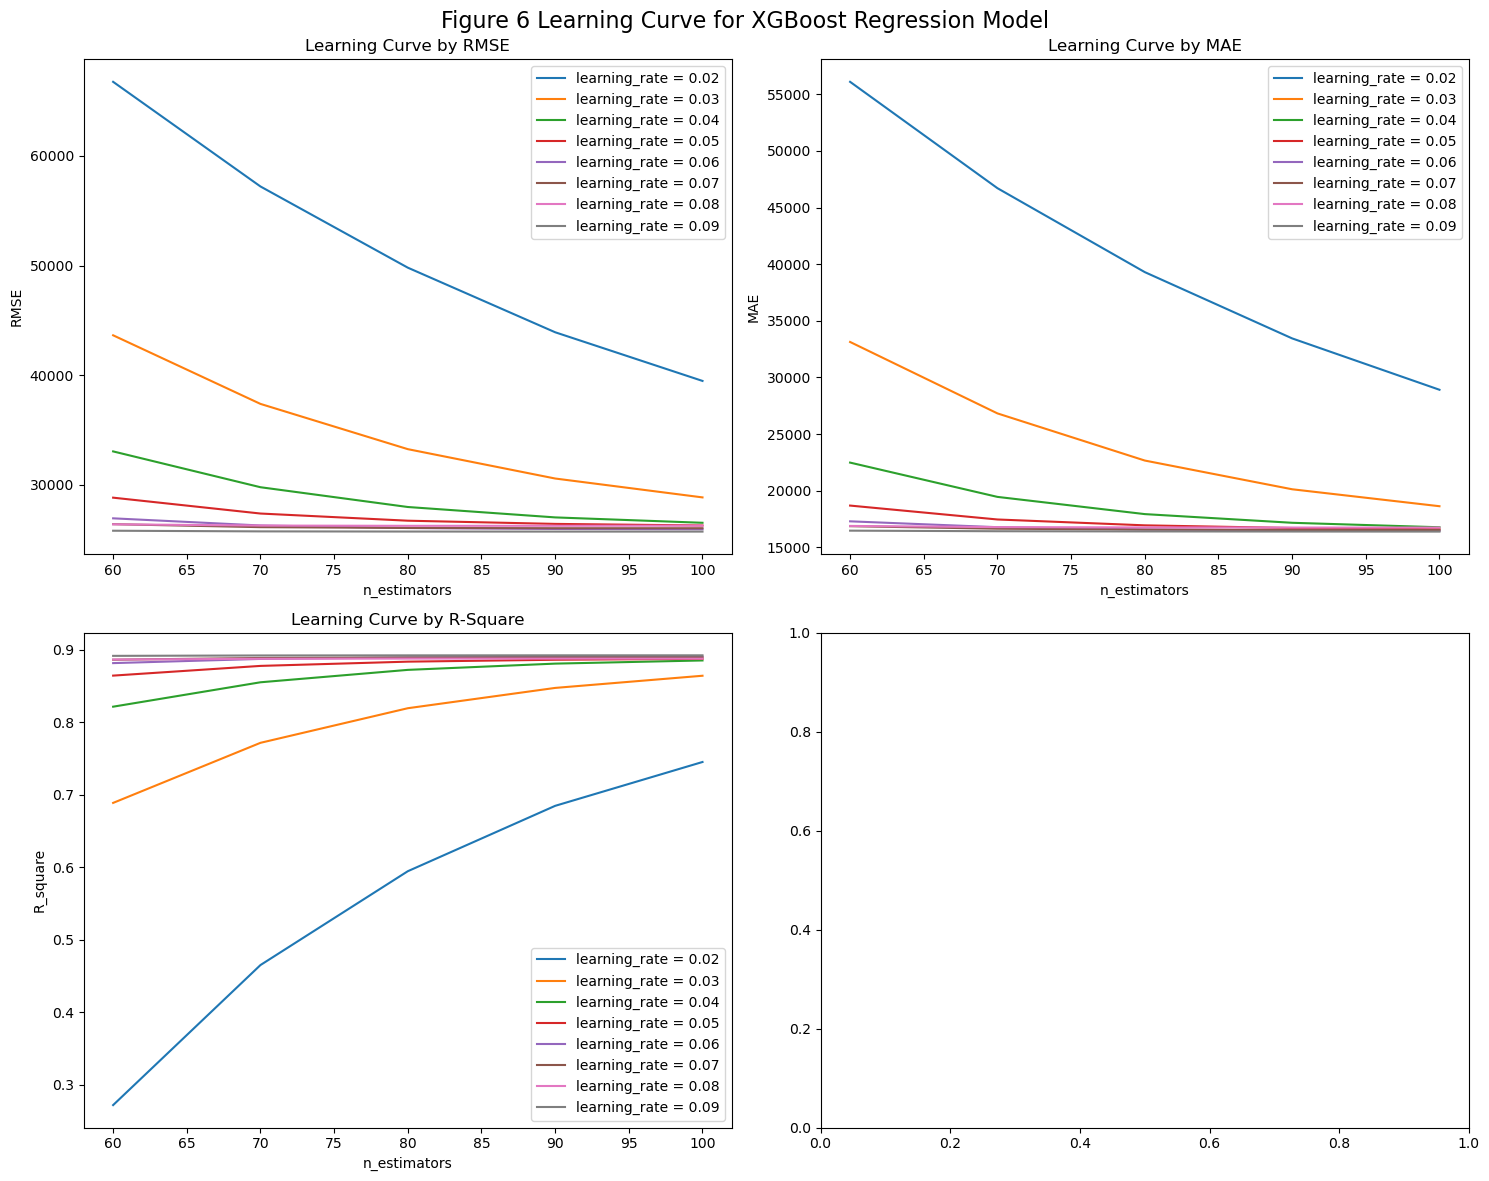

0.8923007916161072 66748.79249300688 56096.64390882965


In [34]:
# Extract results
n_estimators_values = parameters['n_estimators']
max_depth_values = parameters['learning_rate']

results_mae = GS_mae.cv_results_
mean_mae = -results_mae['mean_test_score']

results_mse = GS_mse.cv_results_
mean_rmse = np.sqrt(-results_mse['mean_test_score'])

results_r2 = GS_r2.cv_results_
mean_r2 = results_r2['mean_test_score']

#Reshape mean_mae to a 2D array for plotting
mean_mae = mean_mae.reshape(len(max_depth_values), len(n_estimators_values))
mean_rmse = mean_rmse.reshape(len(max_depth_values), len(n_estimators_values))
mean_r2 = mean_r2.reshape(len(max_depth_values), len(n_estimators_values))

fig, axs = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Figure 6 Learning Curve for XGBoost Regression Model", fontsize=16)
# Plot the R2 curve
for i, max_depth in enumerate(max_depth_values):
    axs[1,0].plot(n_estimators_values, mean_r2[i], label=f'learning_rate = {round(max_depth,2)}')
axs[1,0].set_title("Learning Curve by R-Square")
axs[1,0].legend()
axs[1,0].set_xlabel("n_estimators")
axs[1,0].set_ylabel("R_square")
# Plot the MAE curve
for i, max_depth in enumerate(max_depth_values):
    axs[0,1].plot(n_estimators_values, mean_mae[i], label=f'learning_rate = {round(max_depth,2)}')
axs[0,1].set_title("Learning Curve by MAE")
axs[0,1].legend()
axs[0,1].set_xlabel("n_estimators")
axs[0,1].set_ylabel("MAE")

for i, max_depth in enumerate(max_depth_values):
    axs[0,0].plot(n_estimators_values, mean_rmse[i], label=f'learning_rate = {round(max_depth,2)}')
axs[0,0].set_title("Learning Curve by RMSE")
axs[0,0].legend()
axs[0,0].set_xlabel("n_estimators")
axs[0,0].set_ylabel("RMSE")

plt.tight_layout()
plt.show()

print(np.max(mean_r2),np.max(mean_rmse),np.max(mean_mae))

In [29]:
mean_mae

array([56109.16226829, 56096.64390883, 56119.72696333, 46742.51405176,
       46705.62596669, 46750.89690264, 39315.50912169, 39294.76625742,
       39336.55119773, 33486.19961934, 33443.03275542, 33505.29222612,
       28949.73073177, 28907.31780358, 29008.52879536, 33258.38179413,
       33128.566973  , 33282.51536183, 26909.32614506, 26821.04774813,
       26843.08022565, 22769.34136731, 22658.39782548, 22755.19253619,
       20231.87239845, 20122.08765978, 20231.56869486, 18700.69263353,
       18625.47100862, 18746.70795341, 22597.21028062, 22476.39834557,
       22670.66850715, 19525.12411052, 19448.96748675, 19653.23761137,
       17995.63081558, 17929.01032218, 18128.7318009 , 17209.6155724 ,
       17162.81460671, 17343.46826971, 16796.71044326, 16767.49064785,
       16943.0150216 , 18531.56272584, 18682.39907902, 18760.56749006,
       17331.25616228, 17454.37620582, 17564.19697235, 16820.76944182,
       16937.26932871, 17001.60749862, 16590.58304413, 16699.95323634,
      

In [24]:
kf = KFold(n_splits=2, shuffle=True, random_state=0)
# custom_decision_tree = DecisionTreeRegressor(max_depth=16
#                                             ,min_samples_leaf= 1
#                                             ,min_samples_split = 4)

parameters = { 'n_estimators':[100]
                ,'learning_rate':[0.09]
                ,'subsample':[0.93]
                ,'max_depth':[16]
                ,'booster':["gbtree"]
                }
XGB = XGBRegressor(random_state=0)
GS_mae = GridSearchCV(XGB, parameters, cv=kf, scoring="neg_mean_absolute_error")
GS_mae.fit(Xtrain_tree, Ytrain_lr)
GS_mse = GridSearchCV(XGB, parameters, cv=kf, scoring="neg_mean_squared_error")
GS_mse.fit(Xtrain_tree, Ytrain_lr)
GS_r2 = GridSearchCV(XGB, parameters, cv=kf, scoring="r2")
GS_r2.fit(Xtrain_tree, Ytrain_lr)
print(GS_r2.best_params_)
print(GS_r2.best_score_)
print(GS_mae.best_params_)
print(GS_mae.best_score_)
print(GS_mse.best_params_)
print(np.sqrt(-GS_mse.best_score_))

{'booster': 'gbtree', 'learning_rate': 0.09, 'max_depth': 16, 'n_estimators': 100, 'subsample': 0.93}
0.8923007916161072
{'booster': 'gbtree', 'learning_rate': 0.09, 'max_depth': 16, 'n_estimators': 100, 'subsample': 0.93}
-16384.846677303784
{'booster': 'gbtree', 'learning_rate': 0.09, 'max_depth': 16, 'n_estimators': 100, 'subsample': 0.93}
25749.96310617534


In [25]:
kf = KFold(n_splits=2, shuffle=True, random_state=0)
# custom_decision_tree = DecisionTreeRegressor(max_depth=16
#                                             ,min_samples_leaf= 1
#                                             ,min_samples_split = 4)

parameters = { 'n_estimators':[100]
                ,'learning_rate':[0.09]
                ,'subsample':[0.93]
                ,'max_depth':[16]
                ,'booster':["gbtree"]
                }
XGB = XGBRegressor(random_state=0)
GS_mae = GridSearchCV(XGB, parameters, cv=kf, scoring="neg_mean_absolute_error")
GS_mae.fit(Xtest_tree, Ytest_lr)
GS_mse = GridSearchCV(XGB, parameters, cv=kf, scoring="neg_mean_squared_error")
GS_mse.fit(Xtest_tree, Ytest_lr)
GS_r2 = GridSearchCV(XGB, parameters, cv=kf, scoring="r2")
GS_r2.fit(Xtest_tree, Ytest_lr)
print(GS_r2.best_params_)
print(GS_r2.best_score_)
print(GS_mae.best_params_)
print(GS_mae.best_score_)
print(GS_mse.best_params_)
print(np.sqrt(-GS_mse.best_score_))

{'booster': 'gbtree', 'learning_rate': 0.09, 'max_depth': 16, 'n_estimators': 100, 'subsample': 0.93}
0.7950599673445019
{'booster': 'gbtree', 'learning_rate': 0.09, 'max_depth': 16, 'n_estimators': 100, 'subsample': 0.93}
-18984.204437767752
{'booster': 'gbtree', 'learning_rate': 0.09, 'max_depth': 16, 'n_estimators': 100, 'subsample': 0.93}
37022.39044941078
